In [1]:
using Revise

In [2]:
include("gp_utility.jl")

plot_low_sigma_gp_realizations (generic function with 1 method)

In [3]:
using CmdStan
using CmdStanExtract

using DataFrames
using Plots
using Serialization
using Statistics

In [4]:
data = deserialize("gp.data")

(N = 11, x = -10.0:2.0:10.0, y = [-0.305988, -2.4159, -1.06836, 4.05275, 1.84246, -0.656602, -1.50408, 2.57574, -4.94042, -0.533326, -1.23523], N_predict = 501, x_predict = -10.0:0.04:10.0, y_predict = [-0.305988, 3.34174, -2.6149, 1.61098, 1.05581, -2.00876, -0.240148, -0.453517, 2.8017, 0.648663  …  -2.89914, 0.412148, -3.11129, -0.265462, -1.21106, 1.2445, 0.210053, 0.494353, -3.15261, -1.23523])

In [5]:
true_realization = deserialize("gp.truth")

(f_total = [0.440999, 0.450114, 0.459221, 0.468386, 0.477522, 0.486707, 0.495902, 0.505064, 0.514232, 0.523393  …  -1.01733, -1.01536, -1.0135, -1.01182, -1.01025, -1.00878, -1.0075, -1.00633, -1.00529, -1.00435], x_total = -10.0:0.04:10.0, sigma_true = 2)

In [6]:
simu_gauss_dgp = "
data {
  int<lower=1> N;
  real f[N];
  real<lower=0> sigma;
}

parameters {}
model {}

generated quantities {
  vector[N] y_predict;
  for (n in 1:N)
    y_predict[n] = normal_rng(f[n], sigma);
}
"

f_data = Dict(
    "sigma" => true_realization.sigma_true,
    "N" => length(true_realization.f_total),
    "f" => true_realization.f_total
)

dgp_fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="simu_gauss_dgp", model=simu_gauss_dgp, nchains=1, num_samples=1000, 
    random=CmdStan.Random(5838298)
), f_data, summary=false);



File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/simu_gauss_dgp.stan will be updated.



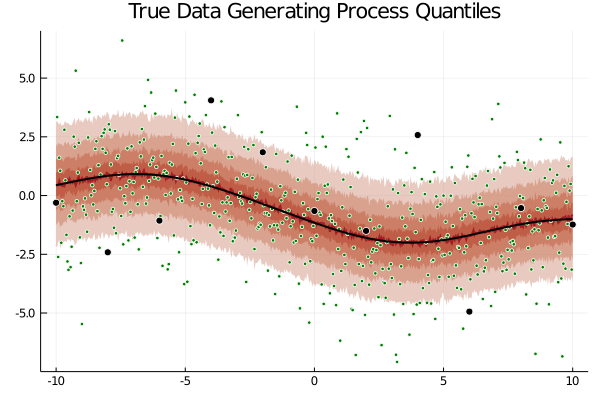

In [7]:
plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True Data Generating Process Quantiles")


In [8]:
gp1 = "
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(square(sigma), N));
  matrix[N, N] L_cov = cholesky_decompose(cov);

  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);
}
"
;

In [9]:
data_dict = Dict(String(key) => value for (key, value) in zip(keys(data), data))

Dict{String,Any} with 6 entries:
  "x_predict" => -10.0:0.04:10.0
  "N"         => 11
  "x"         => -10.0:2.0:10.0
  "N_predict" => 501
  "y_predict" => [-0.305988, 3.34174, -2.6149, 1.61098, 1.05581, -2.00876, -0.2…
  "y"         => [-0.305988, -2.4159, -1.06836, 4.05275, 1.84246, -0.656602, -1…

In [10]:
gp1_model = Stanmodel(
    # Sample(algorithm=CmdStan.Fixed_param()), 
    name="gp1", model=gp1, 
    random=CmdStan.Random(5838298)
)

# such error, many divergents

fit = open("tmp/stderr.txt", "w") do out
    redirect_stderr(out) do
        stan(gp1_model, data_dict, summary=true);
    end
end


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/gp1.stan will be updated.

Input files: gp1_samples_1.csv, gp1_samples_2.csv, gp1_samples_3.csv, gp1_samples_4.csv
Ouput csv_file: gp1_summary.csv
Inference for Stan model: gp1_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.11, 0.12, 0.11, 0.14) seconds, 0.48 seconds total
Sampling took (0.099, 0.067, 0.44, 0.051) seconds, 0.66 seconds total

                   Mean     MCSE   StdDev       5%      50%      95%  N_Eff  N_Eff/s    R_hat

lp__            6.9e+02  6.6e-02  1.3e+00  6.9e+02  6.9e+02  7.0e+02    361      547  1.0e+00
accept_stat__      0.78  7.8e-02     0.27     0.00     0.89     1.00     12       18  1.1e+00
stepsize__         0.18  7.9e-02     0.11    0.022     0.22     0.33    2.0      3.0  2.0e+14
treedepth__         3.0  9.6e-01      1.7     0.00      3.0      6.0    3.3      5.0  1.6e+00
n_leapfrog__         22

(0, [695.221 0.666667 … 3939.57 2.36648; 695.262 0.833312 … 6688.87 2.35598; … ; 694.563 0.945046 … 46770.0 2.06436; 694.135 0.888085 … 33256.5 1.96336]

[693.781 0.888889 … 245.551 2.13474; 692.824 0.832773 … 56.6185 2.48385; … ; 694.852 0.833326 … 6315.05 3.31094; 694.783 0.799995 … 1000.57 3.31422]

[694.676 0.916667 … 1571.66 2.65157; 694.584 0.990291 … 5041.54 2.63951; … ; 694.446 0.926008 … 2.66741e7 2.97059; 694.553 0.950585 … 2.27893e6 2.73017]

[693.261 0.995107 … 458945.0 2.36637; 692.238 0.782168 … 1574.66 2.13109; … ; 693.458 0.855915 … 17373.5 2.10113; 693.851 0.916245 … 863.068 3.01865], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "rho", "alpha", "sigma"])

In [11]:
read_summary(gp1_model)

,parameters,mean,mcse,std,5%,50%,95%
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,lp__,693.912,0.0659069,1.25265,691.452,694.224,695.269
2,accept_stat__,0.77964,0.0782091,0.272624,0.0,0.888085,0.999642
3,stepsize__,0.181212,0.0789872,0.111873,0.0221282,0.224356,0.329069
4,treedepth__,2.9845,0.95689,1.73537,0.0,3.0,6.0
5,n_leapfrog__,22.4505,18.0307,33.5142,1.0,9.0,104.0
6,divergent__,0.87125,0.00881273,0.334965,0.0,1.0,1.0
7,energy__,-692.423,0.074263,1.74842,-694.675,-692.749,-688.996
8,rho,8.60495e307,Inf,Inf,9.31872e306,8.34731e307,1.67187e308
9,alpha,1.09997e7,2.34604e6,3.5753e7,0.909436,7745.07,7.65475e7


In [12]:
params = extract(fit)

Dict{String,Array} with 10 entries:
  "treedepth__"   => [1.0 3.0 3.0 4.0; 2.0 2.0 6.0 2.0; … ; 4.0 2.0 4.0 3.0; 3.…
  "n_leapfrog__"  => [3.0 9.0 12.0 15.0; 6.0 6.0 103.0 5.0; … ; 25.0 6.0 30.0 9…
  "sigma"         => [2.36648 2.13474 2.65157 2.36637; 2.35598 2.48385 2.63951 …
  "energy__"      => [-694.607 -693.221 -689.326 -691.683; -694.741 -689.462 -6…
  "lp__"          => [695.221 693.781 694.676 693.261; 695.262 692.824 694.584 …
  "alpha"         => [3939.57 245.551 1571.66 458945.0; 6688.87 56.6185 5041.54…
  "accept_stat__" => [0.666667 0.888889 0.916667 0.995107; 0.833312 0.832773 0.…
  "divergent__"   => [1.0 1.0 1.0 0.0; 1.0 1.0 1.0 1.0; … ; 1.0 1.0 1.0 1.0; 1.…
  "stepsize__"    => [0.149294 0.224356 0.0221282 0.329069; 0.149294 0.224356 0…
  "rho"           => [1.50508e308 4.89009e307 8.0412e307 2.11999e307; 1.58056e3…

In [13]:
@show sum(params["divergent__"])  prod(size(params["divergent__"]))

sum(params["divergent__"]) = 3485.0
prod(size(params["divergent__"])) = 4000


4000

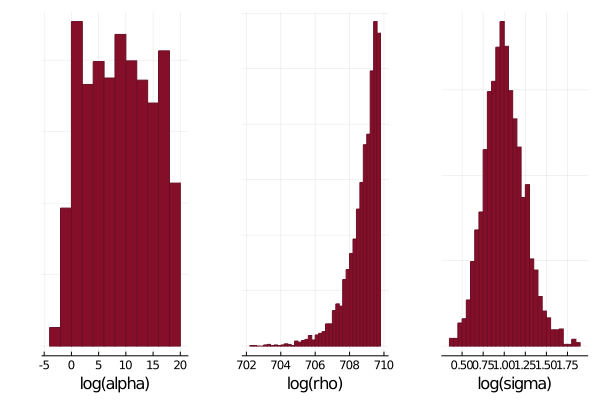

In [14]:
l = @layout [a b c]

p1 = histogram(log.(vec(params["alpha"])), xlabel="log(alpha)", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)

p2 = histogram(log.(vec(params["rho"])), xlabel="log(rho)", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)

p3 = histogram(log.(vec(params["sigma"])), xlabel="log(sigma)", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)

plot(p1, p2, p3, layout = l)

In [15]:
gp2 = "
functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(square(sigma), N));
  matrix[N, N] L_cov = cholesky_decompose(cov);

  rho ~ normal(0, 20.0 / 3);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 1);
  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);
}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;
  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}
"
;

In [16]:
gp2_model = Stanmodel(
    # Sample(algorithm=CmdStan.Fixed_param()), 
    name="gp2", model=gp2, 
    random=CmdStan.Random(5838298)
)

fit = open("tmp/stdout.txt", "w") do out
    redirect_stdout(out) do
        stan(gp2_model, data_dict, summary=true);
    end
end
;


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/gp2.stan will be updated.



In [17]:
check_all_diagnostics(gp2_model, fit)

min_n_eff_iter_ratio = 0.0909155
min_n_eff_iter_ratio > 0.001 = true
max_r_hat = 1.00634
max_r_hat < 1.1 = true
sum(params["divergent__"]) = 12.0
mean(params["divergent__"]) = 0.003
max_treedepth = 5.0
max_treedepth < 10 = true
ebfmi = 0.8925377493674234
ebfmi > 0.2 = true


true

In [18]:
div_params, nondiv_params = partition_div(fit);

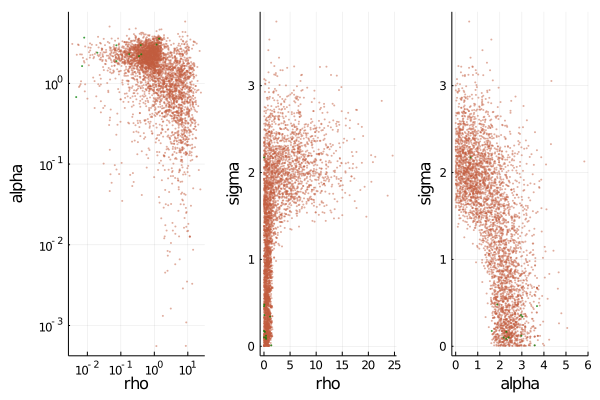

In [19]:
l = @layout [a b c]

p_list = Any[]

for (xname, yname, xscale, yscale) in [("rho", "alpha", :log10, :log10), 
                                       ("rho", "sigma", :identity, :identity),
                                       ("alpha", "sigma", :identity, :identity)]
    p = scatter(nondiv_params[xname], nondiv_params[yname], 
        fmt=:png, xscale=xscale, yscale=yscale, alpha=0.5, markersize=2,
        color=colorschemes[:amp][125], markerstrokewidth=0, legend=false, xlabel=xname, ylabel=yname)

    scatter!(div_params[xname], div_params[yname], 
        fmt=:png, xscale=xscale, yscale=yscale, alpha=0.75, markersize=2,
        color=:green, markerstrokewidth=0, legend=false)
    
    push!(p_list, p)
end

plot(p_list..., layout=l)

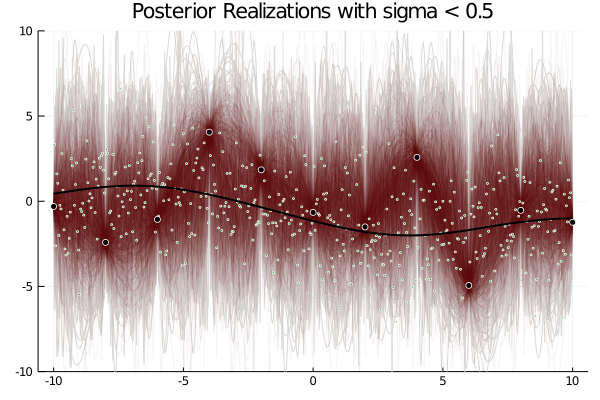

In [20]:
plot_low_sigma_gp_realizations(fit, data, true_realization,
                               "Posterior Realizations with sigma < 0.5")

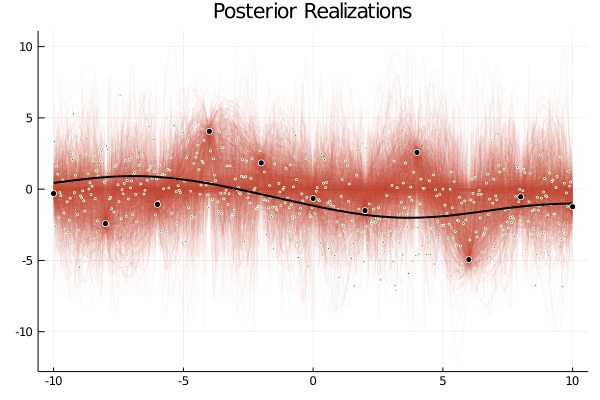

In [21]:
plot_gp_realizations(fit, data, true_realization,
                     "Posterior Realizations")


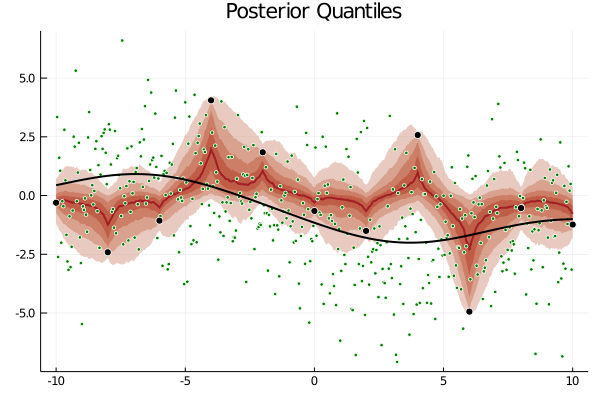

In [22]:
plot_gp_quantiles(fit, data, true_realization,
                  "Posterior Quantiles")


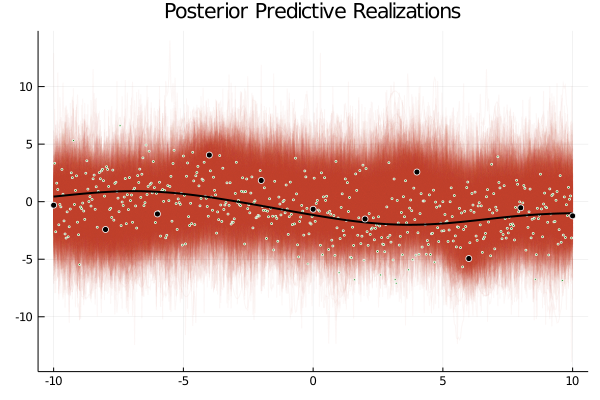

In [23]:
plot_gp_pred_realizations(fit, data, true_realization,
                     "Posterior Predictive Realizations")


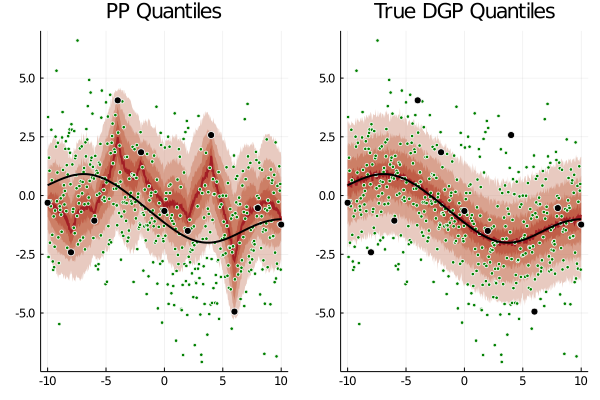

In [24]:
l = @layout [a b]

p1 = plot_gp_pred_quantiles(fit, data, true_realization,
                       "PP Quantiles")
p2 = plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True DGP Quantiles")

plot(p1, p2, layout=l)

In [25]:
gp_prior_tune = """
functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
    deltas[2] = 1 - inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - 0.01;
    return deltas;
  }
}

transformed data {
  vector[2] y_guess = [log(10), log(20)]';
  vector[2] theta = [2, 10]';
  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("a = ", exp(y[1]));
  print("b = ", exp(y[2]));
}
"""
;

In [26]:
fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="gp_prior_tune", model=gp_prior_tune, nchains=1, num_samples=1, 
    random=CmdStan.Random(5838298)
), summary=false);



File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/gp_prior_tune.stan will be updated.



In [27]:
open("tmp/gp_prior_tune_run.log", "r") do f
    println(String(read(f)))
end

method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file =  (Default)
init = 2 (Default)
random
  seed = 5838298
output
  file = gp_prior_tune_samples_1.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

a = 8.91924
b = 34.5805
Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0 seconds (Sampling)
               0 seconds (Total)




In [28]:
gp3 = "
functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(square(sigma), N));
  matrix[N, N] L_cov = cholesky_decompose(cov);

  // P[rho < 2.0] = 0.01
  // P[rho > 10] = 0.01
  rho ~ inv_gamma(8.91924, 34.5805);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 1);

  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);
}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;
  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}
"

gp3_model = Stanmodel(
    # Sample(algorithm=CmdStan.Fixed_param()), 
    name="gp3", model=gp3, 
    random=CmdStan.Random(5838298)
)
;


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/gp3.stan will be updated.



In [29]:
fit = open("tmp/stdout.txt", "w") do out
    redirect_stdout(out) do
        stan(gp3_model, data_dict, summary=true);
    end
end
;

In [30]:
check_all_diagnostics(gp3_model, fit)

min_n_eff_iter_ratio = 0.5500325
min_n_eff_iter_ratio > 0.001 = true
max_r_hat = 1.0016
max_r_hat < 1.1 = true
sum(params["divergent__"]) = 0.0
mean(params["divergent__"]) = 0.0
max_treedepth = 4.0
max_treedepth < 10 = true
ebfmi = 0.9793381389700794
ebfmi > 0.2 = true


true

In [31]:
params = extract(fit);

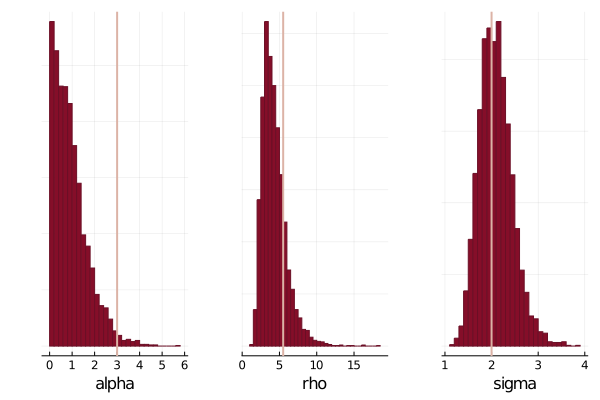

In [32]:
l = @layout [a b c]

p1 = histogram(vec(params["alpha"]), xlabel="alpha", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)
vline!([3], linecolor=colorschemes[:amp][50], width=2)

p2 = histogram(vec(params["rho"]), xlabel="rho", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)
vline!([5.5], linecolor=colorschemes[:amp][50], width=2)

p3 = histogram(vec(params["sigma"]), xlabel="sigma", 
    fillcolor=colorschemes[:amp][200], linecolor=colorschemes[:amp][220], showaxis=:x, legend=false)
vline!([2], linecolor=colorschemes[:amp][50], width=2)

plot(p1, p2, p3, layout = l)

In [33]:
div_params, nondiv_params = partition_div(fit);

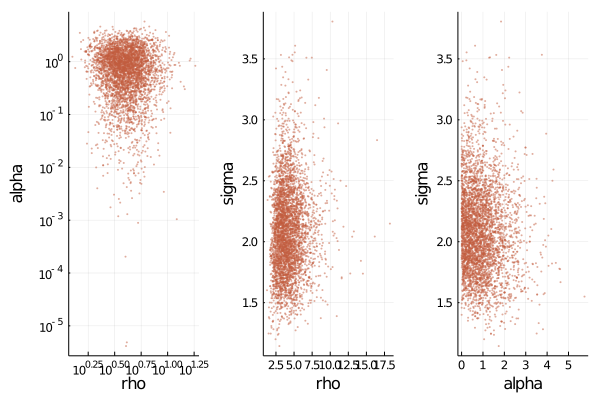

In [34]:
l = @layout [a b c]

p_list = Any[]

for (xname, yname, xscale, yscale) in [("rho", "alpha", :log10, :log10), 
                                       ("rho", "sigma", :identity, :identity),
                                       ("alpha", "sigma", :identity, :identity)]
    p = scatter(nondiv_params[xname], nondiv_params[yname], 
        fmt=:png, xscale=xscale, yscale=yscale, alpha=0.5, markersize=2,
        color=colorschemes[:amp][125], markerstrokewidth=0, legend=false, xlabel=xname, ylabel=yname)

    scatter!(div_params[xname], div_params[yname], 
        fmt=:png, xscale=xscale, yscale=yscale, alpha=0.75, markersize=2,
        color=:green, markerstrokewidth=0, legend=false)
    
    push!(p_list, p)
end

plot(p_list..., layout=l)

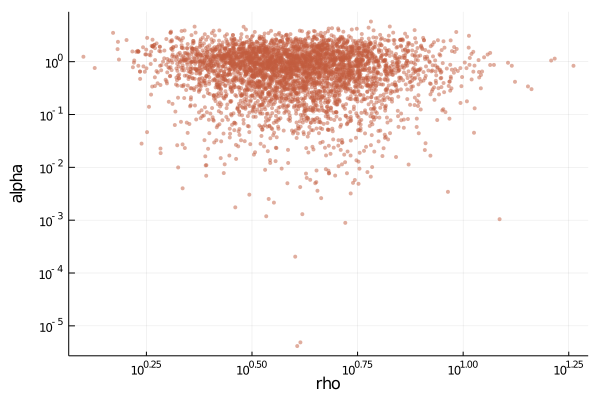

In [35]:
let (xname, yname, xscale, yscale) = ("rho", "alpha", :log10, :log10)
    scatter(nondiv_params[xname], nondiv_params[yname], 
            fmt=:png, xscale=xscale, yscale=yscale, alpha=0.5, markersize=3,
            color=colorschemes[:amp][125], markerstrokewidth=0, legend=false, xlabel=xname, ylabel=yname)
end

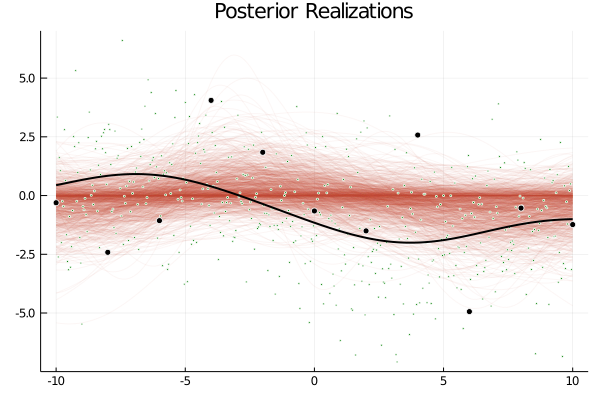

In [36]:
plot_gp_realizations(fit, data, true_realization,
                     "Posterior Realizations")


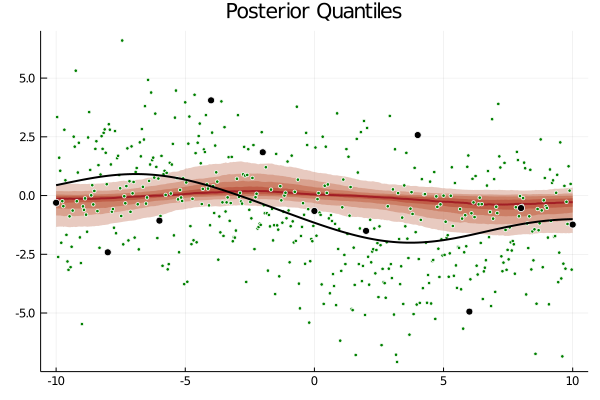

In [37]:
plot_gp_quantiles(fit, data, true_realization,
                  "Posterior Quantiles")


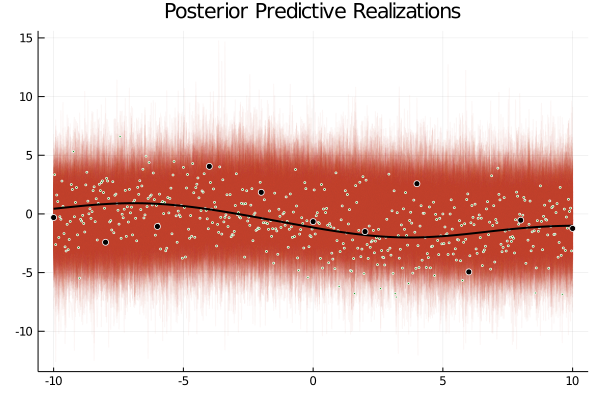

In [38]:
plot_gp_pred_realizations(fit, data, true_realization,
                     "Posterior Predictive Realizations")


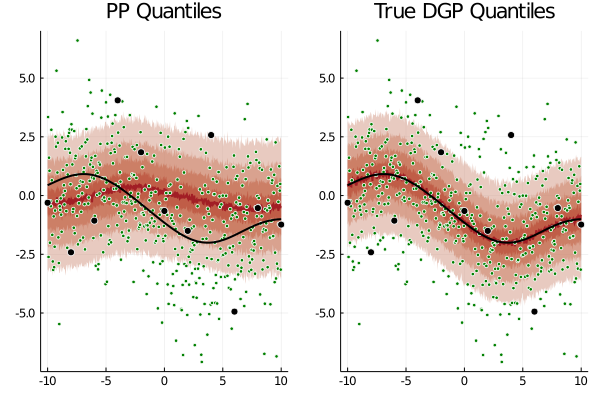

In [39]:
l = @layout [a b]

p1 = plot_gp_pred_quantiles(fit, data, true_realization,
                       "PP Quantiles")

p2 = plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True DGP Quantiles")

plot(p1, p2, layout=l)